In [75]:
!pip install dwave-qbsolv

In [76]:
from dwave.system import DWaveSampler, EmbeddingComposite
from neal import SimulatedAnnealingSampler
import numpy as np
import dimod
import networkx as nx
import matplotlib.pyplot as plt
import hybrid
from dwave_qbsolv import QBSolv
%matplotlib inline         

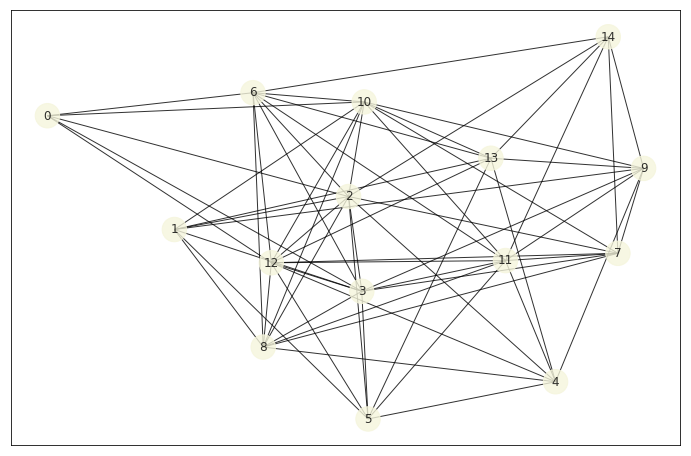

Sample(sample={'0_0': 0, '0_1': 0, '0_2': 0, '0_3': 0, '0_4': 1, '0_5': 0, '0_6': 0, '10_0': 0, '10_1': 0, '10_2': 0, '10_3': 0, '10_4': 0, '10_5': 1, '10_6': 0, '11_0': 0, '11_1': 0, '11_2': 0, '11_3': 1, '11_4': 0, '11_5': 0, '11_6': 0, '12_0': 1, '12_1': 0, '12_2': 0, '12_3': 0, '12_4': 0, '12_5': 0, '12_6': 0, '13_0': 0, '13_1': 1, '13_2': 0, '13_3': 0, '13_4': 0, '13_5': 0, '13_6': 0, '14_0': 1, '14_1': 0, '14_2': 0, '14_3': 0, '14_4': 0, '14_5': 0, '14_6': 0, '1_0': 1, '1_1': 0, '1_2': 0, '1_3': 0, '1_4': 0, '1_5': 0, '1_6': 0, '2_0': 0, '2_1': 0, '2_2': 0, '2_3': 1, '2_4': 0, '2_5': 0, '2_6': 0, '3_0': 0, '3_1': 0, '3_2': 1, '3_3': 0, '3_4': 0, '3_5': 0, '3_6': 0, '4_0': 0, '4_1': 0, '4_2': 1, '4_3': 0, '4_4': 0, '4_5': 0, '4_6': 0, '5_0': 0, '5_1': 0, '5_2': 0, '5_3': 0, '5_4': 1, '5_5': 0, '5_6': 0, '6_0': 0, '6_1': 0, '6_2': 0, '6_3': 0, '6_4': 0, '6_5': 0, '6_6': 1, '7_0': 0, '7_1': 1, '7_2': 0, '7_3': 0, '7_4': 0, '7_5': 0, '7_6': 0, '8_0': 0, '8_1': 0, '8_2': 0, '8_3': 0, 

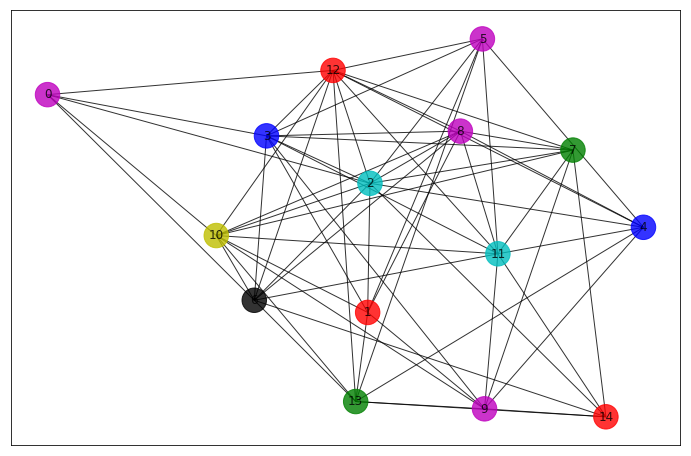

In [122]:
n_nodes = 15

def plot_graph(G, colors = ['beige']*n_nodes):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    plt.show()
    
def generate_random_graph(n, p = 0.6):
    return(nx.gnp_random_graph(n, p))

def graph_to_adjacency(G):
    mat = nx.adjacency_matrix(G).todense()
    return(tuple(mat.tolist()))

def graphcolour_QUBO(G, ncolours, constr=10):
    #We start initialising the QUBO matrix
    Q = {}
    for i in range(0,len(G)):
        for j in range(0,ncolours):
            for k in range(0,len(G)):
                for l in range(0,ncolours):
                    Q[(str(i) + "_" + str(j), str(k) + "_" + str(l))] = 0
            
    #Objective, we dont want adjacent vertices to share the colour
    for i in range(0,len(G)):
        for j in range(0,ncolours):
            for k in range(i+1,len(G)):
                if G[i][k] == 1:
                    Q[(str(i) + "_" + str(j), str(k) + "_" + str(j))] = 1
    #Constraint: Every vertex is painted of exactly one colour
    for i in range(0,len(G)):
        for j in range(0,ncolours):
            for k in range(0,ncolours):
                if j == k:
                    Q[(str(i) + "_" + str(j), str(i) + "_" + str(j))] = Q[(str(i) + "_" + str(j), str(i) + "_" + str(j))] - constr
                else:
                    Q[(str(i) + "_" + str(j), str(i) + "_" + str(k))] = Q[(str(i) + "_" + str(j), str(i) + "_" + str(k))] + constr
    return (Q)

def get_colors(final_state):
    colors = ['0'] * n_nodes
    c_map = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'lightpink']

    for k, v in final_state.first[0].items():
        if v == 1:
            if len(k) == 3:
                node = int(k[0])
                color = int(k[-1])
                colors[node] = c_map[color]
            if len(k) == 4:
                node = int(k[0:2])
                color = int(k[-1])
                colors[node] = c_map[color]
    
    return(colors)

def verify_results(G, colors):
    connections = list(G.edges)
    for connection in connections:
        node_1 = connection[0]
        node_2 = connection[1]
    
        if colors[node_1] == colors[node_2]:
            print("Test Failed at", connection)

def get_j(Q):
    j = {}
    for i in list(Q.keys()):
        if i[0] == i[1]:
            j[i[0]] = Q[(i[0], i[1])]
    return(j)

def get_H(Q):
    H = {}
    for i in list(Q.keys()):
        if i[0] != i[1]:
            H[(i[0], i[1])] = Q[(i[0], i[1])]
    return(H)


#Generate random graph
G = generate_random_graph(n_nodes)

n_colors = 7 #max(dict(G.degree()).items(), key = lambda x: x[1])[1]

#Plot Graph
plot_graph(G)

#Get adjacency matrix
adj = graph_to_adjacency(G)

#Get Qubomax(dict(G.degree()).items(), key = lambda x: x[1])[1]
Q = graphcolour_QUBO(adj, n_colors)

'''
#Get linear and quadratic terms
j, H = get_j(Q), get_H(Q)
bqm = dimod.BinaryQuadraticModel(j, H, 0, dimod.BINARY)

# Define the workflow
iteration = hybrid.RacingBranches(
    hybrid.Identity(),
    hybrid.InterruptableTabuSampler(),
    hybrid.EnergyImpactDecomposer(size=2)
    | hybrid.QPUSubproblemAutoEmbeddingSampler()
    | hybrid.SplatComposer()
) | hybrid.ArgMin()
workflow = hybrid.LoopUntilNoImprovement(iteration, convergence=3)

# Solve the problem
init_state = hybrid.State.from_problem(bqm)
final_state = workflow.run(init_state).result()

# Print results
print("Solution: sample={.samples.first}".format(final_state))
'''
sampler = QBSolv() #SimulatedAnnealingSampler()#EmbeddingComposite(DWaveSampler())
final_state = sampler.sample_qubo(Q, num_reads = 1000)
print(final_state.first)

c = get_colors(final_state)

plot_graph(G, c)
verify_results(G, c)